In [1]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [1]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=48)

/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38755 instead
  f"Port {expected} is already in use.\n"


In [16]:
client

<Client: 'tcp://10.0.128.138:39397' processes=3 threads=48, memory=131.31 GiB>

In [17]:
print(client)

<Client: 'tcp://10.0.128.138:39397' processes=3 threads=48, memory=131.31 GiB>


In [18]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [19]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


### Load functions

In [20]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [21]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [22]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [23]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

In [24]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [25]:
timeRange = [8005, 8205]
datelist = np.array(range(timeRange[0],timeRange[1],4))

In [26]:
# Load zeta data
VarToKeep = ['zeta','dA']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix

truth_zeta = xr.open_dataset(filelistTruth)
OSSE_SSHSST_zeta= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT_zeta= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N_zeta= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S_zeta= xr.open_dataset(filelist_SSHSST_XBT_S)

#load grid file
grid = makeROMSGridObject(truth_zeta)

truth_zeta,truth_bu = process_trimVarsROMS(truth_zeta,VarToKeep)
OSSE_SSHSST_zeta,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST_zeta,VarToKeep)
OSSE_SSHSST_XBT_zeta,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_zeta,VarToKeep)
OSSE_SSHSST_XBT_N_zeta,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N_zeta,VarToKeep)
OSSE_SSHSST_XBT_S_zeta,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S_zeta,VarToKeep)

In [27]:
## Load processed history data
outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_EKE_MKE_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'

filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix

truth = xr.open_dataset(filelistTruth)
OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)

In [28]:
# add zeta to other files
truth['zeta']=truth_zeta.zeta
OSSE_SSHSST['zeta']=OSSE_SSHSST_zeta.zeta
OSSE_SSHSST_XBT['zeta']=OSSE_SSHSST_XBT_zeta.zeta
OSSE_SSHSST_XBT_N['zeta']=OSSE_SSHSST_XBT_N_zeta.zeta
OSSE_SSHSST_XBT_S['zeta']=OSSE_SSHSST_XBT_S_zeta.zeta

In [29]:
truth_mke_0 = truth.mke_0
truth_mke_500 = truth.mke_500
OSSE_SSHSST_mke_0 = OSSE_SSHSST.mke_0
OSSE_SSHSST_mke_500 = OSSE_SSHSST.mke_500
OSSE_SSHSST_XBT_mke_0 = OSSE_SSHSST_XBT.mke_0
OSSE_SSHSST_XBT_mke_500 = OSSE_SSHSST_XBT.mke_500
OSSE_SSHSST_XBT_N_mke_0 = OSSE_SSHSST_XBT_N.mke_0
OSSE_SSHSST_XBT_N_mke_500 = OSSE_SSHSST_XBT_N.mke_500
OSSE_SSHSST_XBT_S_mke_0 = OSSE_SSHSST_XBT_S.mke_0
OSSE_SSHSST_XBT_S_mke_500 = OSSE_SSHSST_XBT_S.mke_500

truth_eke_0 = truth.eke_0
truth_eke_500 = truth.eke_500
OSSE_SSHSST_eke_0 = OSSE_SSHSST.eke_0
OSSE_SSHSST_eke_500 = OSSE_SSHSST.eke_500
OSSE_SSHSST_XBT_eke_0 = OSSE_SSHSST_XBT.eke_0
OSSE_SSHSST_XBT_eke_500 = OSSE_SSHSST_XBT.eke_500
OSSE_SSHSST_XBT_N_eke_0 = OSSE_SSHSST_XBT_N.eke_0
OSSE_SSHSST_XBT_N_eke_500 = OSSE_SSHSST_XBT_N.eke_500
OSSE_SSHSST_XBT_S_eke_0 = OSSE_SSHSST_XBT_S.eke_0
OSSE_SSHSST_XBT_S_eke_500 = OSSE_SSHSST_XBT_S.eke_500

In [30]:
calc_areaAverageROMS(OSSE_SSHSST_XBT_S_mke_500-truth_mke_500,truth_bu)

<xarray.DataArray ()>
array(0.00149411)

# Raw MKE field plots

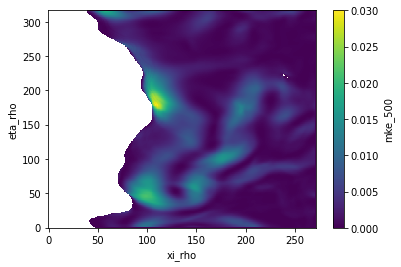

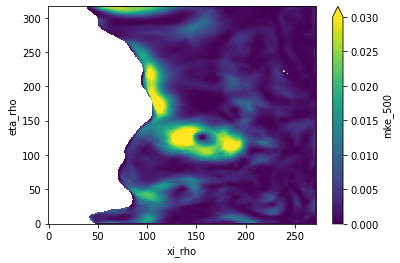

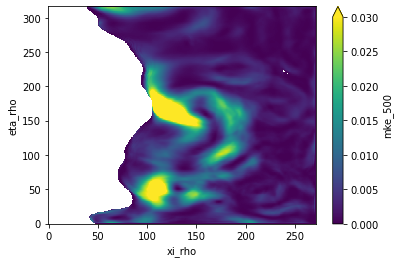

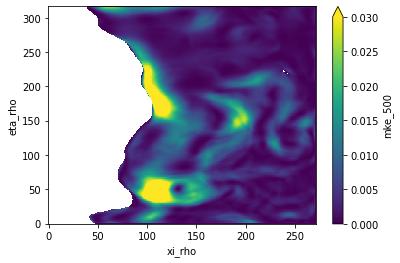

In [31]:
plt.figure()
((truth_mke_500)).plot(vmin=0,vmax=0.03)#/truth_mke_500).plot(vmin=-100,vmax=100)
plt.figure()
((OSSE_SSHSST_mke_500)).plot(vmin=0,vmax=0.03)#/truth_mke_500).plot(vmin=-100,vmax=100)
plt.figure()
((OSSE_SSHSST_XBT_N_mke_500)).plot(vmin=0,vmax=0.03)#/truth_mke_500).plot(vmin=-100,vmax=100)
plt.figure()
((OSSE_SSHSST_XBT_S_mke_500)).plot(vmin=0,vmax=0.03)#/truth_mke_500).plot(vmin=-100,vmax=100)



##### These fields show the MKE nicely. They show spatial distribution (which is important for discussing replication of key features)

# Difference in MKE plots

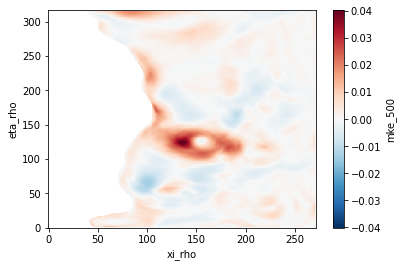

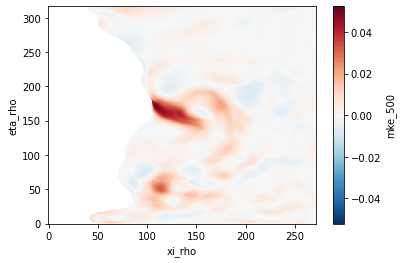

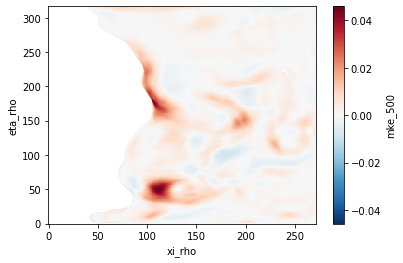

In [32]:

plt.figure()
((OSSE_SSHSST_mke_500-truth_mke_500)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)
plt.figure()
((OSSE_SSHSST_XBT_N_mke_500-truth_mke_500)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)
plt.figure()
((OSSE_SSHSST_XBT_S_mke_500-truth_mke_500)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)



##### The difference fields are OK, but they can be overly weighted by differences in high or low var regions. e.g. the 'donut' in the SSHSST field shows up well, but the near non-existence of the EAC southwards, return flow and eastern ext. is not shown.

# Difference divided by truth plots

diff, SSHSST-truth/truth <xarray.DataArray ()>
array(5.3618794)
diff, XBT_N-truth/truth <xarray.DataArray ()>
array(4.7866367)
diff, XBT_S-truth/truth <xarray.DataArray ()>
array(4.9008665)


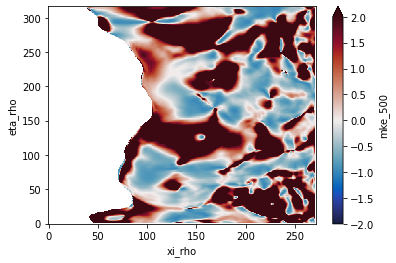

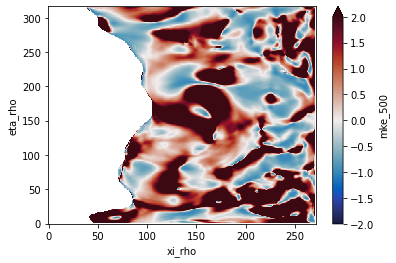

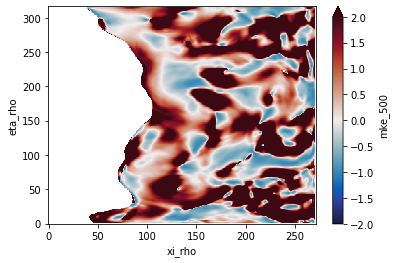

In [33]:

# difference
plt.figure()
((OSSE_SSHSST_mke_500-truth_mke_500)/truth_mke_500).plot(vmin=-2,vmax=2,cmap='cmo.balance')
plt.figure()
((OSSE_SSHSST_XBT_N_mke_500-truth_mke_500)/truth_mke_500).plot(vmin=-2,vmax=2,cmap='cmo.balance')
plt.figure()
((OSSE_SSHSST_XBT_S_mke_500-truth_mke_500)/truth_mke_500).plot(vmin=-2,vmax=2,cmap='cmo.balance')
print("diff, SSHSST-truth/truth", calc_areaAverageROMS((OSSE_SSHSST_mke_500-truth_mke_500)/truth_mke_500,truth_bu))
print("diff, XBT_N-truth/truth", calc_areaAverageROMS((OSSE_SSHSST_XBT_N_mke_500-truth_mke_500)/truth_mke_500,truth_bu))
print("diff, XBT_S-truth/truth", calc_areaAverageROMS((OSSE_SSHSST_XBT_S_mke_500-truth_mke_500)/truth_mke_500,truth_bu))


##### Dividing by the truth field is sensitive to low MKE regions - and the regions we are interested in, which are the white areas here, are not noticeable amongst the high mag values.

# Add hatching

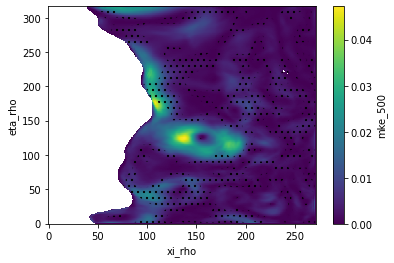

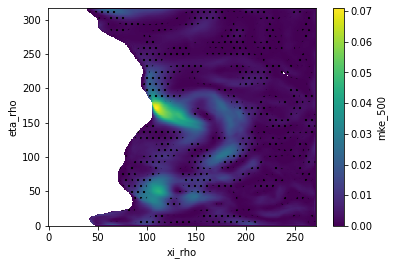

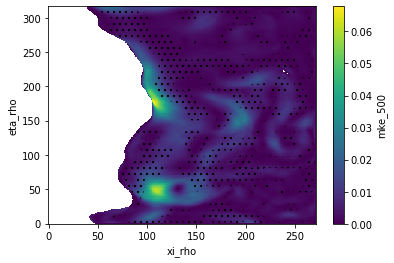

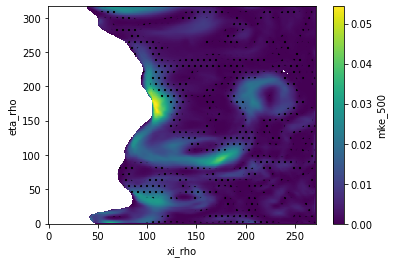

In [34]:
# plt.figure()
# ((OSSE_SSHSST_mke_500)).plot(vmin=0,vmax=0.03)#/truth_mke_500).plot(vmin=-100,vmax=100)
# plt.figure()
# ((OSSE_SSHSST_XBT_S_mke_500)).plot(vmin=0,vmax=0.03)#/truth_mke_500).plot(vmin=-100,vmax=100)
# plt.figure()
# ((OSSE_SSHSST_mke_500-truth_mke_500)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)
# plt.figure()
# ((OSSE_SSHSST_XBT_S_mke_500-truth_mke_500)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)

def calc_hatchFillArea(input,threshold,type):
    if type=='gt':
        [m,n] = np.where(input > threshold)
    elif type=='lt':
        [m,n] = np.where(input < threshold)
    
    z1=np.zeros(input.shape)
    z1[m, n] = 99
    return z1

diff_thresh=.5
diff_hatch_S = calc_hatchFillArea(abs((OSSE_SSHSST_XBT_S_mke_500-truth_mke_500)/truth_mke_500),diff_thresh,'lt')
diff_hatch_N = calc_hatchFillArea(abs((OSSE_SSHSST_XBT_N_mke_500-truth_mke_500)/truth_mke_500),diff_thresh,'lt')
diff_hatch_SSHSST = calc_hatchFillArea(abs((OSSE_SSHSST_mke_500-truth_mke_500)/truth_mke_500),diff_thresh,'lt')
diff_hatch_XBT = calc_hatchFillArea(abs((OSSE_SSHSST_XBT_mke_500-truth_mke_500)/truth_mke_500),diff_thresh,'lt')

# use contourf() with proper hatch pattern and alpha value
plt.figure()
((OSSE_SSHSST_mke_500)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)
plt.contourf(diff_hatch_SSHSST, 3,  colors='none', hatches=['', '..'])
plt.figure()
((OSSE_SSHSST_XBT_N_mke_500)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)
plt.contourf(diff_hatch_N, 3,  colors='none', hatches=['', '..'])
plt.figure()
((OSSE_SSHSST_XBT_S_mke_500)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)
plt.contourf(diff_hatch_S, 3,  colors='none', hatches=['', '..'])
plt.figure()
((OSSE_SSHSST_XBT_mke_500)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)
plt.contourf(diff_hatch_XBT, 3,  colors='none', hatches=['', '..'])

##### Tested adding hatching for when the relative difference (X-truth)/truth is less than some threshold (50% here). But it doesn't pick up the key features I want to talk about, like better representaion of the return flow, eastern ext. etc.

In [35]:
# # try again for 0m

# plt.figure()
# ((OSSE_SSHSST_mke_0-truth_mke_0)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)
# plt.figure()
# ((OSSE_SSHSST_XBT_N_mke_0-truth_mke_0)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)
# plt.figure()
# ((OSSE_SSHSST_XBT_S_mke_0-truth_mke_0)).plot()#/truth_mke_500).plot(vmin=-100,vmax=100)


# # difference
# plt.figure()
# ((OSSE_SSHSST_mke_0-truth_mke_0)/truth_mke_0).plot(vmin=-4,vmax=4,cmap='cmo.balance')
# plt.figure()
# ((OSSE_SSHSST_XBT_N_mke_0-truth_mke_0)/truth_mke_0).plot(vmin=-4,vmax=4,cmap='cmo.balance')
# plt.figure()
# ((OSSE_SSHSST_XBT_S_mke_0-truth_mke_0)/truth_mke_0).plot(vmin=-4,vmax=4,cmap='cmo.balance')



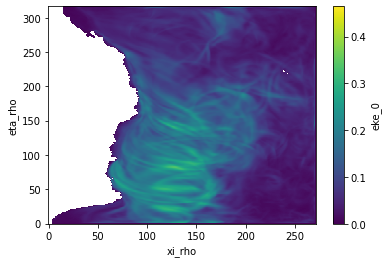

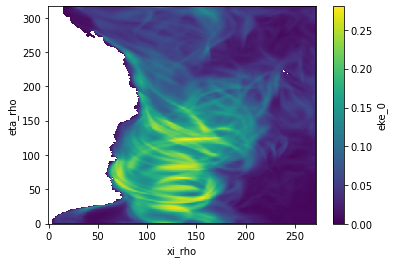

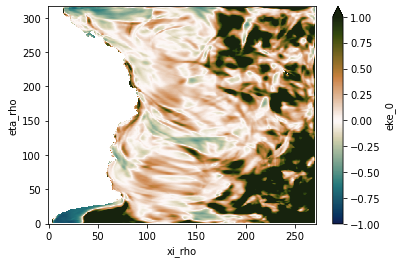

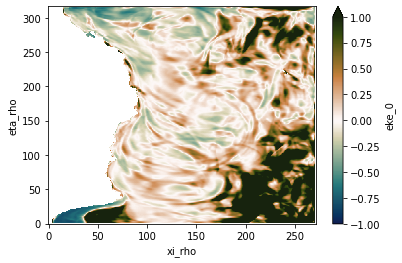

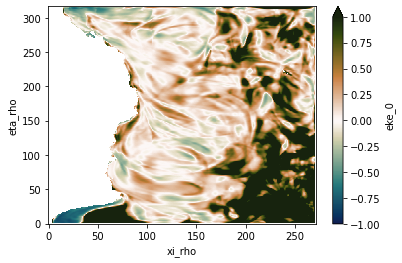

In [36]:
plt.figure()
((((OSSE_SSHSST_eke_0-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)).plot()
plt.figure()
(truth_eke_0.std(dim='ocean_time')).plot()
plt.figure()
((((OSSE_SSHSST_eke_0-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)/(truth_eke_0.std(dim='ocean_time'))-1).plot(vmax=1,cmap='cmo.tarn_r')
plt.figure()
((((OSSE_SSHSST_XBT_S_eke_0-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)/(truth_eke_0.std(dim='ocean_time'))-1).plot(vmax=1,cmap='cmo.tarn_r')
plt.figure()
((((OSSE_SSHSST_XBT_eke_0-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)/(truth_eke_0.std(dim='ocean_time'))-1).plot(vmax=1,cmap='cmo.tarn_r')

#ax8 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_XBT_eke_500-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)  ,gs,4,4,'e',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})


##### Here we're showing EKE. So I can not calculate an RMS and compare against the STD of the truth field. I like the idea, but the resulting fields are dominated by regions where the denominator is small. (e.g. bottom right, bottom left corners). Likewise, the key region (the high EKE variability) region is down-weighted.

##### Note that I'm not calculating the std of the u,v inputs (I'm calculating std(EKE)).

# compare MAE and RMSD


Text(0.5, 1.0, 'RMSD')

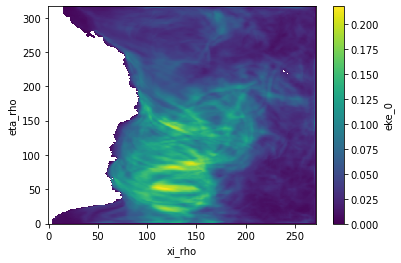

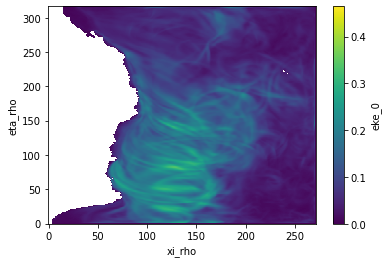

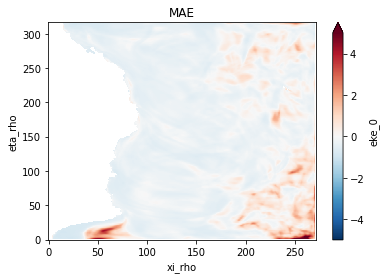

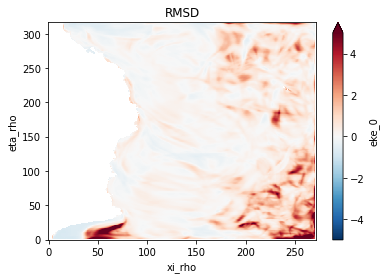

In [48]:
plt.figure()
((abs(OSSE_SSHSST_eke_0-truth_eke_0)).mean(dim='ocean_time')).plot()
plt.figure()
((((OSSE_SSHSST_eke_0-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)).plot()
plt.figure()
((abs(OSSE_SSHSST_eke_0-truth_eke_0)).mean(dim='ocean_time')/(truth_eke_0.std(dim='ocean_time'))-1).plot(vmax=5)
plt.title('MAE')
plt.figure()
((((OSSE_SSHSST_eke_0-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)/(truth_eke_0.std(dim='ocean_time'))-1).plot(vmax=5)
plt.title('RMSD')

##### MAE might be a bit better at showing lower error through the high var region, compared to RMSD (which seems to be overly influenced by the zonal bands of EKE).

# test the MAE with a variety of OSSEs

Text(0.5, 1.0, 'MAE XBT')

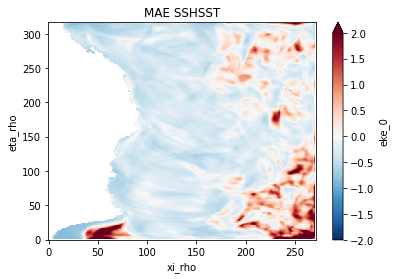

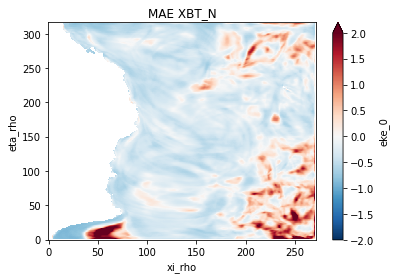

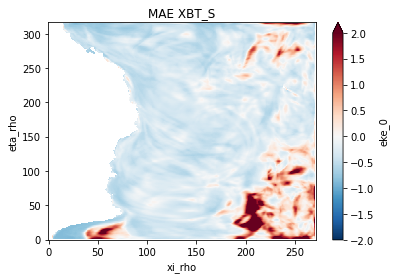

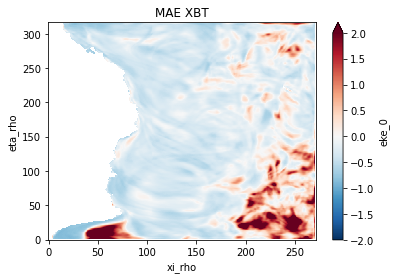

In [52]:
plt.figure()
((abs(OSSE_SSHSST_eke_0-truth_eke_0)).mean(dim='ocean_time')/(truth_eke_0.std(dim='ocean_time'))-1).plot(vmax=2)
plt.title('MAE SSHSST')
plt.figure()
((abs(OSSE_SSHSST_XBT_N_eke_0-truth_eke_0)).mean(dim='ocean_time')/(truth_eke_0.std(dim='ocean_time'))-1).plot(vmax=2)
plt.title('MAE XBT_N')
plt.figure()
((abs(OSSE_SSHSST_XBT_S_eke_0-truth_eke_0)).mean(dim='ocean_time')/(truth_eke_0.std(dim='ocean_time'))-1).plot(vmax=2)
plt.title('MAE XBT_S')
plt.figure()
((abs(OSSE_SSHSST_XBT_eke_0-truth_eke_0)).mean(dim='ocean_time')/(truth_eke_0.std(dim='ocean_time'))-1).plot(vmax=2)
plt.title('MAE XBT')

##### MAE is less sensitive to outlying values, but the division by the std deviation leads to very large values in all fields. It's difficult to detect differences in the blue areas / regions we're interested in.

<Figure size 432x288 with 0 Axes>

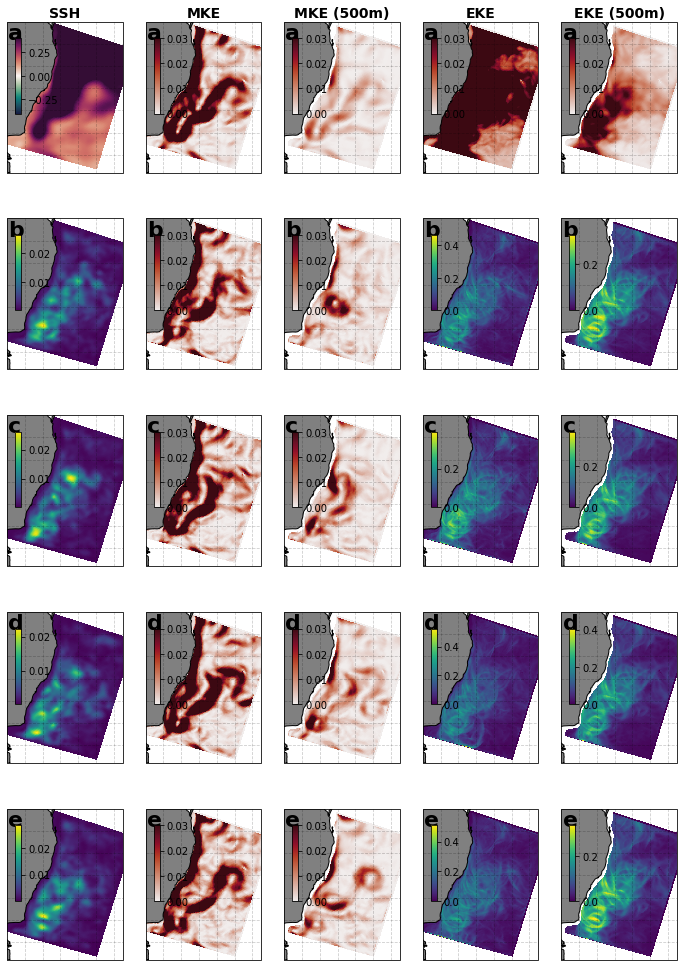

In [53]:
## define
def addSubplot_spatialMap_contourf(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.contourf(input.lon_rho,input.lat_rho,input,levels,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax


def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax


# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=5,ncols=5)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12,17.5])
ax = None


# # add plots
# # top row

###
ax7 = addSubplot_spatialMap_pcolor(truth.zeta.mean(dim='ocean_time')  ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.curl','vmin':-.4,'vmax':0.4})
ax7.text(0.5, 1.1, 'SSH',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((truthSurf.mke),truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST.zeta-truth.zeta)**2).mean(dim='ocean_time'))*(1/2)   ,gs,1,0,'b',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_XBT_N.zeta-truth.zeta)**2).mean(dim='ocean_time'))*(1/2)   ,gs,2,0,'c',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_XBT_S.zeta-truth.zeta)**2).mean(dim='ocean_time'))*(1/2)   ,gs,3,0,'d',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax8 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_XBT.zeta-truth.zeta)**2).mean(dim='ocean_time'))*(1/2)  ,gs,4,0,'e',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax8.text(0.5, 1.1, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax8.transAxes)

###

ax7 = addSubplot_spatialMap_pcolor(truth_mke_0  ,gs,0,1,'a',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
ax7.text(0.5, 1.1, 'MKE',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((truthSurf.mke),truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( OSSE_SSHSST_mke_0   ,gs,1,1,'b',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor(OSSE_SSHSST_XBT_N_mke_0   ,gs,2,1,'c',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor(OSSE_SSHSST_XBT_S_mke_0   ,gs,3,1,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax8 = addSubplot_spatialMap_pcolor(OSSE_SSHSST_XBT_mke_0  ,gs,4,1,'e',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax8.text(0.5, 1.1, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax8.transAxes)

# (((OSSE_SSHSST_mke_500-truth_mke_500)**2).mean(dim='ocean_time'))**(1/2)/truth_mke_500.std(dim='ocean_time)

###
ax7 = addSubplot_spatialMap_pcolor(truth_mke_500  ,gs,0,2,'a',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
ax7.text(0.5, 1.1, 'MKE (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((truthSurf.mke),truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( OSSE_SSHSST_mke_500   ,gs,1,2,'b',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor(OSSE_SSHSST_XBT_N_mke_500   ,gs,2,2,'c',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor(OSSE_SSHSST_XBT_S_mke_500   ,gs,3,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax8 = addSubplot_spatialMap_pcolor(OSSE_SSHSST_XBT_mke_500  ,gs,4,2,'e',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax8.text(0.5, 1.1, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax8.transAxes)

###
ax7 = addSubplot_spatialMap_pcolor(truth_eke_0.mean(dim='ocean_time')  ,gs,0,3,'a',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
ax7.text(0.5, 1.1, 'EKE',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((truthSurf.mke),truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_eke_0-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)   ,gs,1,3,'b',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_XBT_N_eke_0-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)   ,gs,2,3,'c',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_XBT_S_eke_0-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)   ,gs,3,3,'d',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax8 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_XBT_eke_0-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)  ,gs,4,3,'e',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax8.text(0.5, 1.1, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax8.transAxes)


###
ax7 = addSubplot_spatialMap_pcolor(truth_eke_500.mean(dim='ocean_time')  ,gs,0,4,'a',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.03})
ax7.text(0.5, 1.1, 'EKE (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((truthSurf.mke),truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_eke_500-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)   ,gs,1,4,'b',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_XBT_N_eke_500-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)   ,gs,2,4,'c',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_XBT_S_eke_500-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)   ,gs,3,4,'d',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax8 = addSubplot_spatialMap_pcolor( (((OSSE_SSHSST_XBT_eke_500-truth_eke_0)**2).mean(dim='ocean_time'))**(1/2)  ,gs,4,4,'e',pcol_kwargs={})#'cmap':'cmo.amp','vmin':0,'vmax':0.03})
# ax8.text(0.5, 1.1, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax8.transAxes)


In [ ]:
# RMSD_SSHSST_TRUTH_zeta    = (((OSSE_SSHSST.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_zeta    = (((OSSE_SSHSST_XBT_N.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_zeta    = (((OSSE_SSHSST_XBT_S.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_zeta    = (((OSSE_SSHSST_XBT.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_TRUTH_zeta.load()
# RMSD_SSHSST_XBT_N_TRUTH_zeta.load()
# RMSD_SSHSST_XBT_S_TRUTH_zeta.load()
# RMSD_SSHSST_XBT_TRUTH_zeta.load()

# I_XBT_N_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_N_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100
# I_XBT_S_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_S_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100
# I_XBT_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100

In [ ]:
# RMSD_SSHSST_TRUTH_eke   =
# RMSD_SSHSST_TRUTH_mke   =
# RMSD_SSHSST_TRUTH_eke500=
# RMSD_SSHSST_TRUTH_mke500= (truth_mke_500

In [ ]:
# ## define
# def addSubplot_spatialMap_contourf(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im = ax.contourf(input.lon_rho,input.lat_rho,input,levels,**pcol_kwargs)   
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax


# def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax


# # gs to make a 4 row, 7 col plot
# gs = gridspec.GridSpec(nrows=5,ncols=3)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[12.5,22.5])
# ax = None



# levels=np.arange(-100,110,25)

# # add plots
# # top row
# ax7 = addSubplot_spatialMap_pcolor(truthSurf.mke  ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.amp'})
# ax7.text(0.5, 1.1, 'MKE',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax7 = addSubplot_spatialMap_pcolor(truth_mke_500   ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.amp'})
# ax7.text(0.5, 1.1, 'MKE (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax7 = addSubplot_spatialMap_pcolor(truthSurf.eke.mean(dim='ocean_time')   ,gs,0,2,'b',pcol_kwargs={'cmap':'cmo.thermal'})
# ax7.text(0.5, 1.1, 'EKE',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax7 = addSubplot_spatialMap_pcolor(truth_eke_500   ,gs,0,3,'b',pcol_kwargs={'cmap':'cmo.thermal'})
# ax7.text(0.5, 1.1, 'EKE (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax8 = addSubplot_spatialMap_pcolor(truth.zeta.mean(dim='ocean_time')   ,gs,0,4,'c',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.7})
# truth.zeta.mean(dim='ocean_time').plot.contour(ax=ax8, x='lon_rho',y='lat_rho',colors='k',zorder=12)
# ax8.text(0.5, 1.1, 'SSH',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)



# # ## OSSE_SSHSST row

# ax7 = addSubplot_spatialMap_pcolor(OSSE_SSHSSTSurf.mke  ,gs,1,0,'a',pcol_kwargs={'cmap':'cmo.amp'})
# ax7.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
# ax7 = addSubplot_spatialMap_pcolor(OSSE_SSHSSTSurf.eke.mean(dim='ocean_time')   ,gs,1,1,'b',pcol_kwargs={'cmap':'cmo.thermal'})

# ax8 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_zeta   ,gs,1,2,'f',)
# ax8.text(0.5, 1.1, 'SSH',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)

# # ## OSSE_SSHSST_XBT_N row
# # ax5 = addSubplot_spatialMap_contourf(I_XBT_N_temp   ,levels,gs,2,0,'g',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# # ax5.text(-.1, .5, 'SSH+SST+XBT_N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# # transectEta=255
# # xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# # yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# # ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# # transectEta=119
# # xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# # yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# # ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# # ax7 = addSubplot_spatialMap_contourf(I_XBT_N_temp500,levels,gs,2,1,'h',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# # ax8 = addSubplot_spatialMap_contourf(I_XBT_N_zeta   ,levels,gs,2,2,'i',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})

# # ## OSSE_SSHSST_XBT_S row
# # ax5 = addSubplot_spatialMap_contourf(I_XBT_S_temp   ,levels,gs,3,0,'j',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# # ax5.text(-.1, .5, 'SSH+SST+XBT_S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# # ax7 = addSubplot_spatialMap_contourf(I_XBT_S_temp500,levels,gs,3,1,'k',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# # ax8 = addSubplot_spatialMap_contourf(I_XBT_S_zeta   ,levels,gs,3,2,'l',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})

# # ## OSSE_SSHSST_XBT row
# # ax5 = addSubplot_spatialMap_contourf(I_XBT_temp   ,levels,gs,4,0,'m',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# # ax5.text(-.1, .5, 'SSH+SST+XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# # ax7 = addSubplot_spatialMap_contourf(I_XBT_temp500,levels,gs,4,1,'n',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# # ax8 = addSubplot_spatialMap_contourf(I_XBT_zeta   ,levels,gs,4,2,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})


In [ ]:
## define
def addSubplot_spatialMap_contourf(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.contourf(input.lon_rho,input.lat_rho,input,levels,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax


def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax


# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=5,ncols=3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,22.5])
ax = None


# add plots
# top row
ax7 = addSubplot_spatialMap_pcolor(truthSurf.mke  ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.amp'})
ax7.text(-.1, .5, 'truth',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
ax7.text(0.5, 1.1, 'MKE',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((truthSurf.mke),truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSSTSurf.mke-truthSurf.mke)   ,gs,1,0,'b',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
ax7.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)   ,gs,2,0,'c',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
ax7.text(-.1, .5, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)   ,gs,3,0,'d',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
ax7.text(-.1, .5, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax8 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)   ,gs,4,0,'e',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
ax8.text(-.1, .5, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax8.transAxes)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax8.transAxes)

###

ax7 = addSubplot_spatialMap_pcolor(truth_mke_500  ,gs,0,1,'a',pcol_kwargs={'cmap':'cmo.amp'})
ax7.text(0.5, 1.1, 'MKE (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((truthSurf.mke),truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_mke_500-truth_mke_500)   ,gs,1,1,'b',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
# ax7.text(0.5, 1.1, 'SSH+SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBT_N_mke_500-truth_mke_500)   ,gs,2,1,'c',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBT_S_mke_500-truth_mke_500)   ,gs,3,1,'d',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax8 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBT_mke_500-truth_mke_500)   ,gs,4,1,'e',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
# ax8.text(0.5, 1.1, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax8.transAxes)

###

ax8 = addSubplot_spatialMap_pcolor(truth.zeta.mean(dim='ocean_time')   ,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.7})
truth.zeta.mean(dim='ocean_time').plot.contour(ax=ax8, x='lon_rho',y='lat_rho',colors='k',zorder=12)
ax8.text(0.5, 1.1, 'SSH',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)




In [ ]:
RMSD_SSHSST_TRUTH_zeta    = (((OSSE_SSHSST.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_N_TRUTH_zeta    = (((OSSE_SSHSST_XBT_N.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_S_TRUTH_zeta    = (((OSSE_SSHSST_XBT_S.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_TRUTH_zeta    = (((OSSE_SSHSST_XBT.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

RMSD_SSHSST_TRUTH_zeta.load()
RMSD_SSHSST_XBT_N_TRUTH_zeta.load()
RMSD_SSHSST_XBT_S_TRUTH_zeta.load()
RMSD_SSHSST_XBT_TRUTH_zeta.load()

I_XBT_N_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_N_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100
I_XBT_S_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_S_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100
I_XBT_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100

In [ ]:
## define
def addSubplot_spatialMap_contourf(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.contourf(input.lon_rho,input.lat_rho,input,levels,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax


def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax


# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=5,ncols=3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,22.5])
ax = None


# add plots
# top row
ax7 = addSubplot_spatialMap_pcolor(truthSurf.mke  ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.amp'})
ax7.text(-.1, .5, 'truth',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
ax7.text(0.5, 1.1, 'MKE',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((truthSurf.mke),truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSSTSurf.mke-truthSurf.mke)   ,gs,1,0,'b',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
ax7.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)   ,gs,2,0,'c',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
ax7.text(-.1, .5, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)   ,gs,3,0,'d',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
ax7.text(-.1, .5, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax8 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)   ,gs,4,0,'e',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
ax8.text(-.1, .5, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax8.transAxes)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax8.transAxes)

###

ax7 = addSubplot_spatialMap_pcolor(truth_mke_500  ,gs,0,1,'a',pcol_kwargs={'cmap':'cmo.amp'})
ax7.text(0.5, 1.1, 'MKE (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((truthSurf.mke),truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_mke_500-truth_mke_500)   ,gs,1,1,'b',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
# ax7.text(0.5, 1.1, 'SSH+SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBT_N_mke_500-truth_mke_500)   ,gs,2,1,'c',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_NSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBT_S_mke_500-truth_mke_500)   ,gs,3,1,'d',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
# ax7.text(0.5, 1.1, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBT_SSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax7.transAxes)

ax8 = addSubplot_spatialMap_pcolor((OSSE_SSHSST_XBT_mke_500-truth_mke_500)   ,gs,4,1,'e',pcol_kwargs={'cmap':'cmo.curl','vmin':-.1,'vmax':.1})
# ax8.text(0.5, 1.1, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS((OSSE_SSHSST_XBTSurf.mke-truthSurf.mke)/truthSurf.mke*100,truth).values,4))+' $m^2/s^2$',fontsize=10, va='center', ha='center', transform=ax8.transAxes)

###

ax8 = addSubplot_spatialMap_pcolor(truth.zeta.mean(dim='ocean_time')   ,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.7})
truth.zeta.mean(dim='ocean_time').plot.contour(ax=ax8, x='lon_rho',y='lat_rho',colors='k',zorder=12)
ax8.text(0.5, 1.1, 'SSH',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)


ax8 = addSubplot_spatialMap_pcolor(RMSD_SSHSST_TRUTH_zeta   ,gs,1,2,'f',)

ax8 = addSubplot_spatialMap_pcolor(I_XBT_N_zeta   ,gs,2,2,'i',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_zeta,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)

ax8 = addSubplot_spatialMap_pcolor(I_XBT_S_zeta  ,gs,3,2,'l',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_zeta,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)

ax8 = addSubplot_spatialMap_pcolor(I_XBT_zeta  ,gs,4,2,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_zeta,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
